In [1]:
import pandas as pd
import numpy as np
import os
import requests
from pprint import pprint
from api_key import api_key
import csv
import matplotlib.pyplot as plt

# api_key 를 다른 파일로 분류함.
url = f"http://openapi.seoul.go.kr:8088/{api_key}/json/energyUseDataSummaryInfo/1/5"
df = pd.DataFrame()

In [2]:
# api 데이터 수집 및 누락 데이터 csv 파일 형태로 저장
def get_personal_energy_usage_data():
    responses = []
    f = open('isNull?.csv', 'w', encoding='UTF-8')
    w = csv.writer(f)
    for year in range(2015, 2024 + 1):
        for month in range(1, 12 + 1):
            response = requests.get(f'{url}/{year}/{month:02d}')
            if response.status_code == 200:
                print(f'{year}년 {month}월 api 호출 성공')
                # 개인 키워드만 포함된 데이터만 추출할 수 있도록, filter 함수 이용하여 데이터 규모 축소.
                api_result = list(filter(lambda n: n['MM_TYPE'] == '개인', response.json()['energyUseDataSummaryInfo']['row']))
                
            
                # 개인 데이터가 null 인 경우, 터미널에 추가 출력하고, csv 파일을 생성하여 저장.
                if api_result == []:
                    w.writerow([f'{year}년 {month}월 결측치 발생!'])
                    print(f'{year}년 {month}월 결측치 발생!')
                    responses.append({'YEAR': f'{year}', 'MON': f'{month:02d}', 'MM_TYPE': '개인'})
                else:
                    responses.append(api_result[0])
            else: 
                print(f'API 호출 실패: {response.status_code}')
                f.close()
    f.close()
    return responses

In [3]:
# 데이터 축소하는 코드.
def shrink_data(df):
    renamed_cols = df.rename(columns = {'EUS': '전기', 'GUS': '가스', 'WUS': '수도', 'HUS': '지역난방'})
    selected_cols = renamed_cols[['전기', '가스', '수도', '지역난방', 'YEAR', 'MON']]
    return selected_cols
    

In [4]:
# 데이터 보간하는 내용의 코드, 누락되는 데이터가 많아, 전기, 가스, 수도, 지역난방을 보간하는 방식으로 재작성함.
def interpolate_csv(df_interpolated):
    for col in df_interpolated[['전기', '가스', '수도', '지역난방']]:
        df_interpolated[col] = df_interpolated[col].fillna(df_interpolated[col].interpolate(method = 'spline', order = 3))
    return df_interpolated

# 데이터를 보간하고, 결측치 제거하는 코드. 계절 별로 평균을 낼 경우 더 결측치 제거하는 방식이 더 낫다고 판단함.
def clean_csv(df_cleaned):
    df_cleaned = df.dropna(thresh = df.shape[1] - 1)
    for col in df_cleaned[['전기', '가스', '수도', '지역난방']]:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].interpolate(method = 'spline', order = 3))
    return df_cleaned

In [12]:
# 데이터 전처리 및 보간 코드 통합.
def init_data(df):
    print(df.describe())
    print(df.isnull().sum())
    df_cleaned = clean_csv(df)
    df_interpolated = interpolate_csv(df)
    df_cleaned.to_csv('cleaned_energy.csv', index = False, encoding='UTF-8')
    df_interpolated.to_csv('interpolated_energy.csv', index = False, encoding='UTF-8')

#수집한 데이터가 있는 경우.
if os.path.isfile('energy.csv'):
    df = pd.read_csv('./energy.csv', header=0)
    init_data(df)
# 수집한 데이터가 없는 경우.
else:
    responses = get_personal_energy_usage_data()
    df = pd.DataFrame(responses)
    df = shrink_data(df)
    init_data(df)
    df.to_csv("energy.csv", encoding="UTF-8")

       Unnamed: 0            전기            가스            수도          지역난방  \
count  120.000000  8.300000e+01  8.300000e+01  8.300000e+01  8.300000e+01   
mean    59.500000  2.536563e+08  3.384333e+07  1.414308e+07  1.175129e+07   
std     34.785054  5.627379e+07  2.509535e+07  1.374423e+06  1.420605e+07   
min      0.000000  1.348281e+08  5.729131e+06  7.215169e+06  5.003383e+04   
25%     29.750000  2.210124e+08  1.098092e+07  1.374071e+07  1.485323e+06   
50%     59.500000  2.471430e+08  2.483589e+07  1.427311e+07  8.836296e+06   
75%     89.250000  2.683477e+08  5.556934e+07  1.493014e+07  2.001829e+07   
max    119.000000  4.639713e+08  8.849695e+07  1.661911e+07  1.061349e+08   

              YEAR         MON  
count   120.000000  120.000000  
mean   2019.500000    6.500000  
std       2.884324    3.466527  
min    2015.000000    1.000000  
25%    2017.000000    3.750000  
50%    2019.500000    6.500000  
75%    2022.000000    9.250000  
max    2024.000000   12.000000  
Unnamed: 

/var/folders/70/qp3j84jn70x_68n_k86094v40000gn/T/ipykernel_80386/257098649.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].interpolate(method = 'spline', order = 3))


In [6]:
# 데이터에 계절 칼럼 추가하는 함수
def add_season(df):
    # map 을 이용한 칼럼 작성 도중 더 멋진 방법이 떠올라서 작성함
    # df['season'] =  df['MON'].map(1:'겨울', 2:'겨울', 3:'봄', 4:'봄', 5:'봄', 6:'여름', 7:'여름', 8:'여름', 9:'가을', 10:'가을', 11,
    seasons = np.array(['겨울', '봄', '여름', '가을'])
    df['SEASON'] = seasons[((df['MON'] % 12) // 3)]
    return df

In [14]:
#계절 컬럼 추가하는 데이터 전처리
if os.path.isfile('cleaned_energy.csv'):
    df = pd.read_csv('./cleaned_energy.csv', header=0)
    seasonal_energies = add_season(df)
    df.to_csv("seasonal_energy.csv", encoding='UTF-8')
    

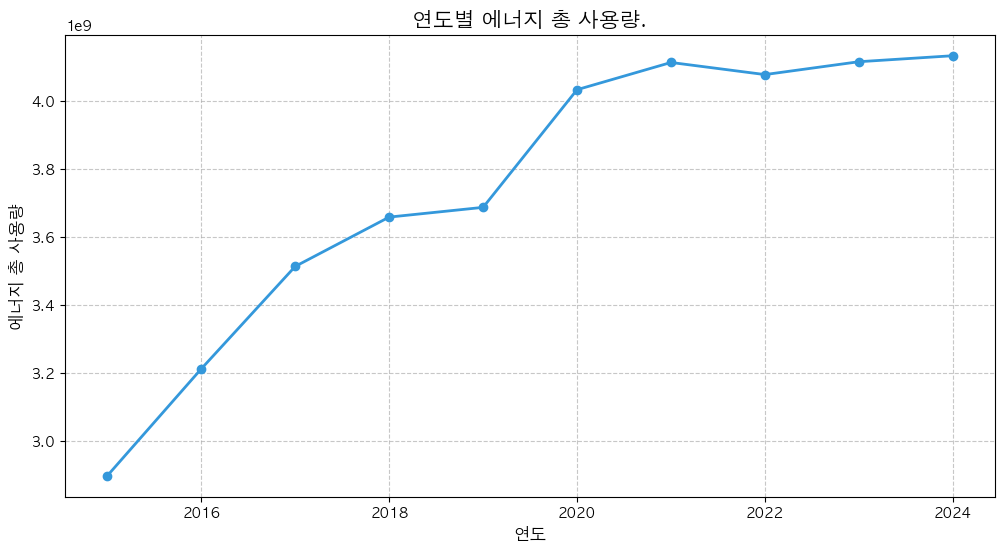

<Figure size 640x480 with 0 Axes>

In [16]:
#문제 3-1 시각화 코드
plt.rc('font', family = 'AppleGothic')

if os.path.isfile('interpolated_energy.csv'):
    df = pd.read_csv('./interpolated_energy.csv', header=0)
    year_total_energy = df.groupby(['YEAR'])[['전기','가스','수도','지역난방']].sum().reset_index()
    year_total_energy['TOTAL'] = year_total_energy['전기'] + year_total_energy['가스'] + year_total_energy['수도'] + year_total_energy['지역난방']
    year_total_energy.to_csv('year_total_energy.csv')
    plt.figure(figsize = (12, 6))
    plt.plot(year_total_energy['YEAR'], year_total_energy['TOTAL'], marker = 'o', linestyle = '-', color = '#3498db', linewidth = 2)

    plt.title('연도별 에너지 총 사용량.', fontsize = 15)
    plt.xlabel('연도', fontsize = 12)
    plt.ylabel('에너지 총 사용량', fontsize = 12)
    plt.grid(True, linestyle = '--', alpha = 0.7)
    plt.show()
    plt.savefig('year_total_energy.pdf')

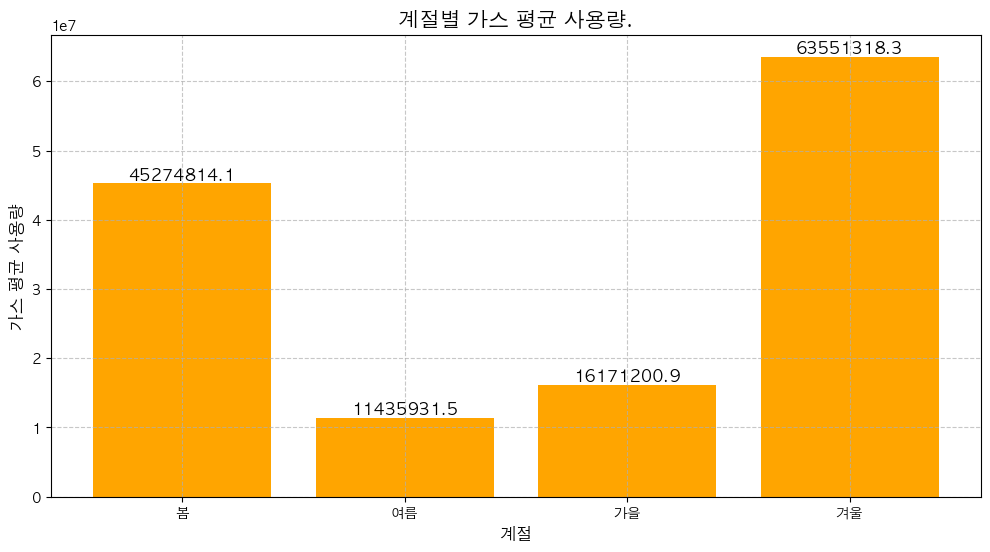

<Figure size 640x480 with 0 Axes>

In [17]:
plt.rc('font', family='AppleGothic')
 
if os.path.isfile('seasonal_energy.csv'):
    df = pd.read_csv('./seasonal_energy.csv', header=0)
    seasons = ['봄', '여름', '가을', '겨울']
    seasonal_gas = df.groupby(['SEASON'])[['가스']].mean().reindex(seasons).reset_index()
    plt.figure(figsize = (12, 6))
    bar = plt.bar(seasonal_gas['SEASON'], seasonal_gas['가스'], color = 'orange')
    plt.title('계절별 가스 평균 사용량.', fontsize = 15)
    plt.xlabel('계절', fontsize = 12)
    plt.ylabel('가스 평균 사용량', fontsize = 12)
    plt.grid(True, linestyle = '--', alpha = 0.7)
    for b in bar:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2.0, h, '%.1f' % h, ha = 'center', va = 'bottom', size = 12)
    plt.show()
    plt.savefig('seasonal_gas.pdf')